#Basketball Lineup Plus-minus Prediction 


##### Kole Laviolette 72088131 Jerry Qi 73382533 Junru Chen 74767625

## Introduction 

  In basketball, there is a statistic called the “plus-minus” (short-handed to “+/-”) that refers to the sum of all of the points scored while they were on the court, minus the sum of all the points they let the opposing team score. This statistic is a good quantifiable value for the overall effect of a line and it can be used to determine the best line for a team to play in a game.
  
  In our project, our group is trying to approximate the plus-minus of a certain line in a basketball game.

  Our dataset contains the statistics of various NBA lineups. In every row of our dataset there are record observations for the following values:
  
TEAM (team names), GP (total games played), and average MIN (minutes played), PTS (points scored), FGM (field goals made), FGA (field goals attempted), FG% (hit rate of all shots), 3PM (number of 3-point shots made), 3PA (number of 3-point shots attempted), 3P% (hit rate of 3-point shots), FTM (number of free throws made), FTA (number of free throws attempted), FT% (hit rate of free throws), OREB (number of offensive rebounds), DREB (number of defensive rebounds), REB (total number of rebounds), AST (number of assists), TOV (number of turnovers), STL (times of getting the ball from opponents), BLK (times of rejecting the opponents’ shots), BLKA (number of shots rejected by opponents), PF (number of fouls), PFD (numebr of fouls by opponents), +/- (plus/minus).



## Preliminary exploratory data analysis
text

In [24]:
library(tidyverse)
library(tidymodels)
lineup_stat <- read_csv("https://raw.githubusercontent.com/JerryQi77/DSCI_Group-Project/main/DSCI_Group_project?token=GHSAT0AAAAAABZQJWZPOUAKKT7OY7UAZ33IY2546GQ")
lineup_stat

Rows: 250 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): TEAM, First Player, Second Player, Third Player, Fourth Player, Fi...
dbl (24): ...1, GP, MIN, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, O...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,TEAM,GP,MIN,PTS,FGM,FGA,FG%,3PM,3PA,⋯,BLK,BLKA,PF,PFD,+/-,First Player,Second Player,Third Player,Fourth Player,Fifth Player
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
0,ORL,19,21.6,52.3,20.4,42.3,48.2,4.3,10.9,⋯,2.2,2.4,8.0,6.9,0.8,E.Fournier,A.Gordon,E.Payton,T.Ross,N.Vucevic
1,MIN,41,21.5,46.3,17.6,37.2,47.4,3.2,9.1,⋯,2.0,2.2,7.8,8.9,-0.9,G.Dieng,Z.LaVine,R.Rubio,K.Towns,A.Wiggins
2,WAS,69,19.5,45.4,17.7,35.9,49.4,4.1,10.1,⋯,1.4,2.0,7.1,7.1,3.4,B.Beal,M.Gortat,M.Morris,O.Porter,J.Wall
3,LAC,46,18.9,44.0,16.2,31.6,51.3,3.8,8.5,⋯,2.0,1.1,6.2,9.3,5.4,B.Griffin,D.Jordan,L.Mbah,C.Paul,J.Redick
4,CLE,27,16.8,40.9,15.3,31.1,49.0,5.0,11.5,⋯,1.4,1.4,5.6,7.1,2.2,K.Irving,L.James,K.Love,J.Smith,T.Thompson
5,CHA,47,16.7,36.2,13.3,29.4,45.1,3.3,9.3,⋯,1.6,2.2,4.6,6.4,1.7,N.Batum,M.Kidd-Gilchrist,K.Walker,M.Williams,C.Zeller
6,PHX,7,16.4,38.3,14.4,29.9,48.3,2.7,7.9,⋯,0.7,1.9,8.4,6.9,0.1,E.Bledsoe,D.Booker,T.Chandler,J.Dudley,T.Warren
7,MIN,38,15.7,34.8,13.3,27.0,49.5,2.2,5.8,⋯,1.4,1.5,5.3,6.2,0.6,G.Dieng,R.Rubio,B.Rush,K.Towns,A.Wiggins
8,CLE,12,15.1,40.2,14.5,27.7,52.4,5.2,10.6,⋯,1.5,1.4,3.5,6.4,9.8,K.Irving,L.James,D.Liggins,K.Love,T.Thompson


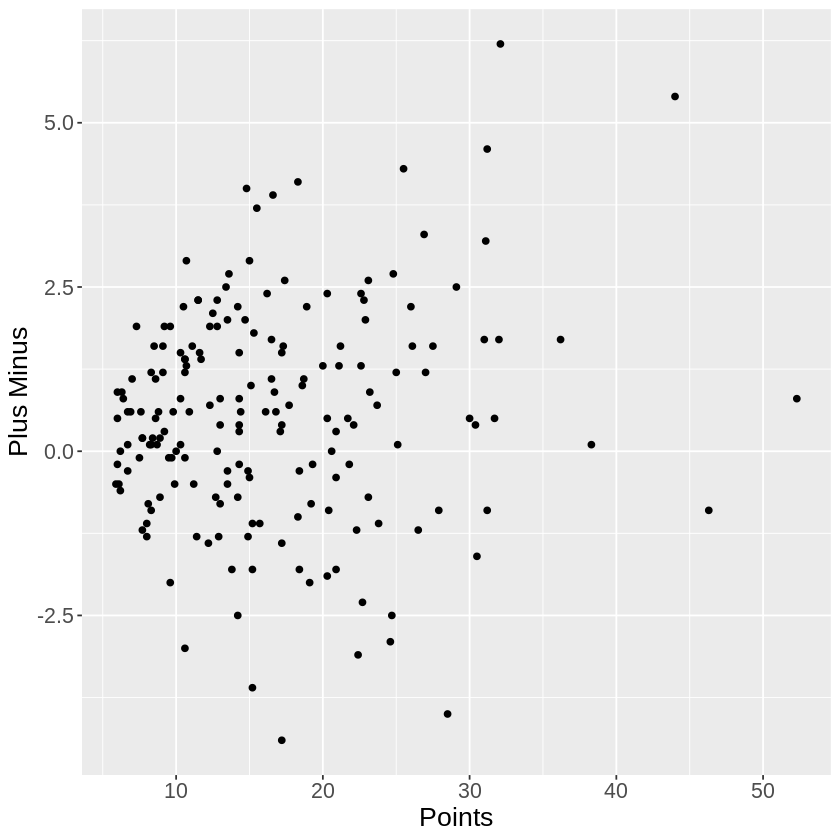

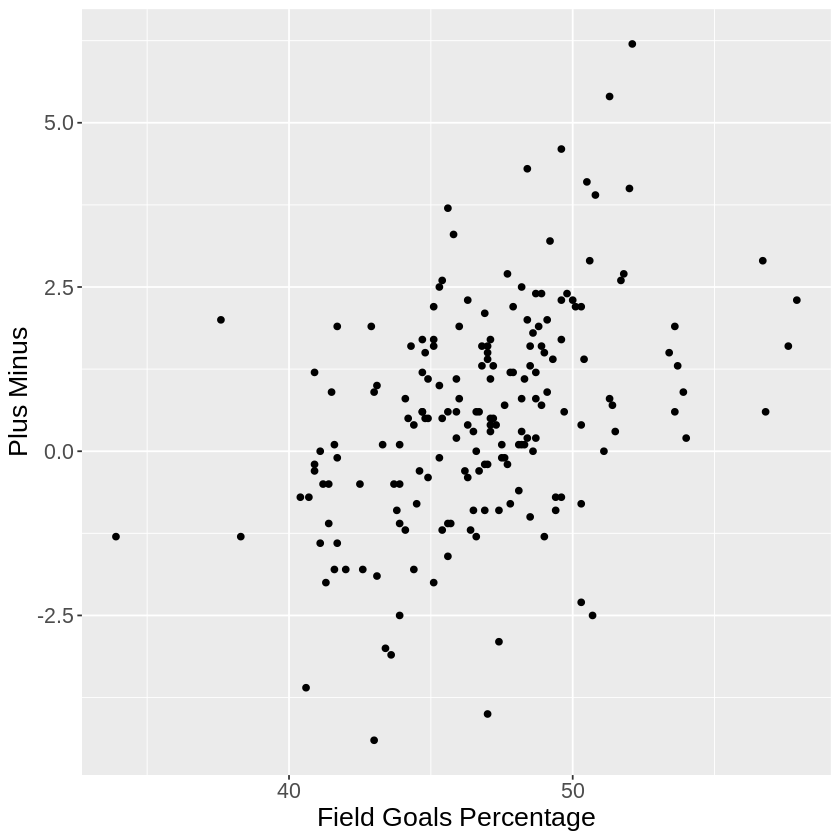

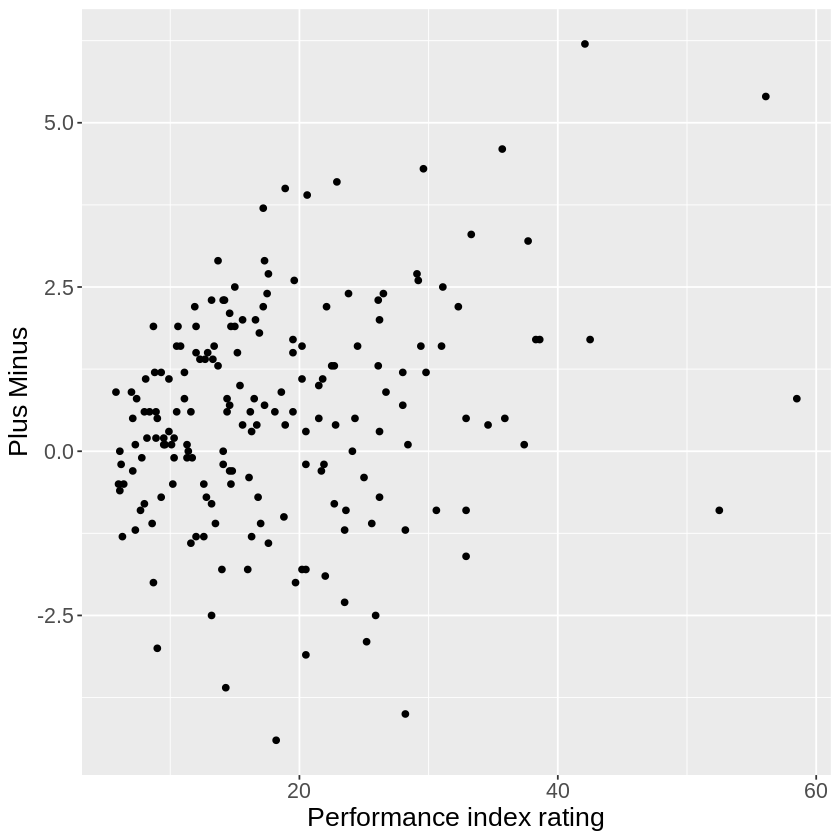

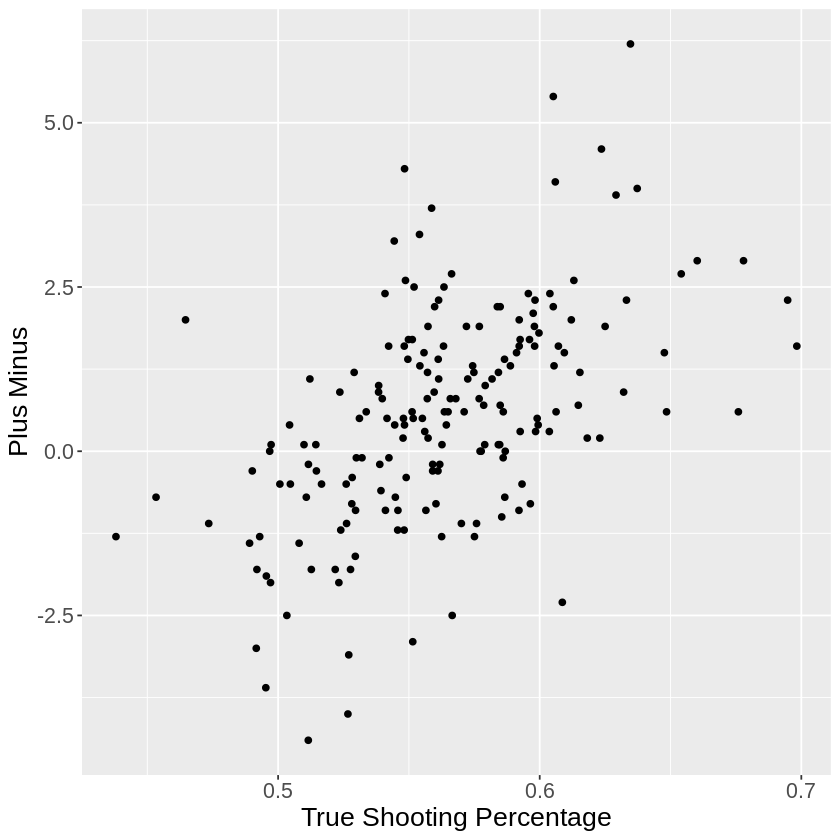

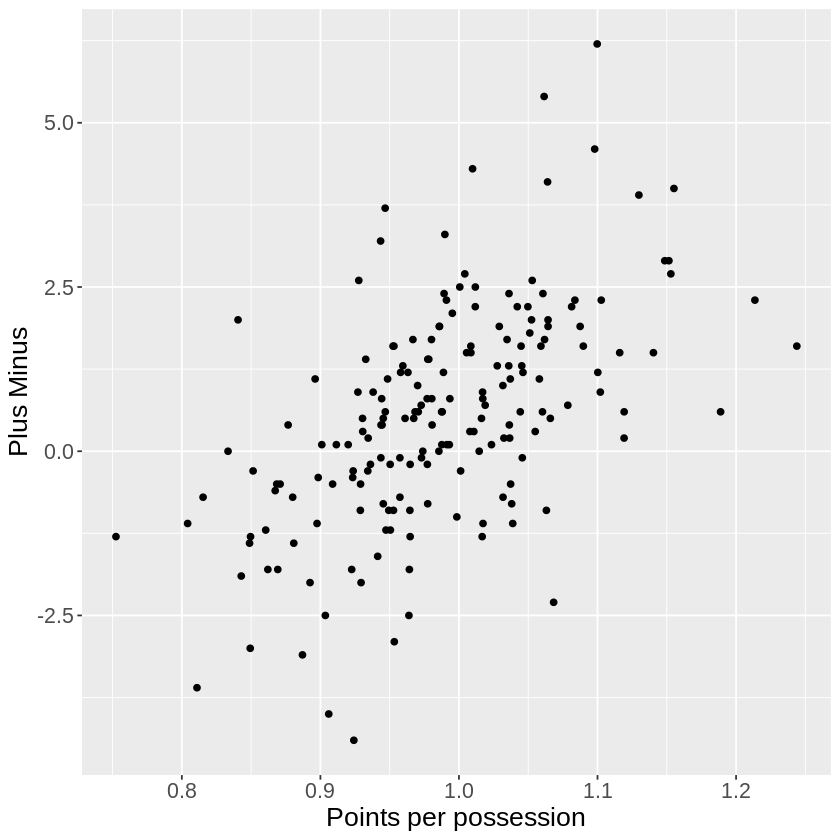

In [27]:
colnames(lineup_stat)[colnames(lineup_stat) == "+/-"] <- "P_M"
colnames(lineup_stat)[colnames(lineup_stat) == "FG%"] <- "FGP"
lineup_stat <- select(lineup_stat, GP:P_M)

lineup_stat <- lineup_stat |>
                 mutate(PIR = PTS + REB + AST + STL + BLK + PFD + FGM - FGA + FTM - FTA - TOV - BLKA - PF) |>
                 mutate(TSP = PTS / ((2 * FGA) + (0.88 * FTA))) |>
                 mutate(PPP = PTS / (FGA + (0.44 * FTA) + TOV))

lineup_split <- initial_split(lineup_stat, prop = 0.75, strata = P_M)
lineup_train <- training(lineup_split)
lineup_test <- testing(lineup_split)

pts_plot <- ggplot(lineup_train, aes(x = PTS, y = P_M)) + geom_point() +
            xlab("Points") + ylab("Plus Minus") + theme(text = element_text(size=16))

fgp_plot <- ggplot(lineup_train, aes(x = FGP, y = P_M)) + geom_point() +
            xlab("Field Goals Percentage") + ylab("Plus Minus") + theme(text = element_text(size=16))

pir_plot <- ggplot(lineup_train, aes(x = PIR, y = P_M)) + geom_point() +
            xlab("Performance index rating") + ylab("Plus Minus") + theme(text = element_text(size=16))

tsp_plot <- ggplot(lineup_train, aes(x = TSP, y = P_M)) + geom_point() +
            xlab("True Shooting Percentage") + ylab("Plus Minus") + theme(text = element_text(size=16))

tsp_plot <- ggplot(lineup_train, aes(x = PPP, y = P_M)) + geom_point() +
            xlab("Points per possession") + ylab("Plus Minus") + theme(text = element_text(size=16))

## Methods


## Expected outcomes and significance: